In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Deconv2D, Conv2DTranspose
from keras.layers import Dense, Conv2D, Flatten
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
###시계열 데이터 load
train_seq = np.load('train_seq_60N_10out.npy')
train_seq_label = np.load('train_seq_label_60N_10out.npy')
#test_seq = np.load('test_seq.npy')
#test_seq_label = np.load('test_seq_label.npy')

np.sum(train_seq_label)

# 정상 데이터만 학습
i, = np.where(train_seq_label==0)
train_seq_T = train_seq[i]


#train_seq_T = train_seq_T[:,:,:16]

X_train = np.expand_dims(train_seq_T, axis=3)
X_train.shape

In [7]:
#######################################
# CNN2D AutoEncoder 구축
#######################################

input_data = Input(shape=X_train.shape[1:]) # 1ch=black&white

#@@ C-AE 구현
filter1 = 8
filter2 = 8
filter3 = 4

x = Conv2D(filter1, kernel_size= (5,5), activation='relu')(input_data)
#x = MaxPooling2D((2,2))(x)
x = Conv2D(filter2, kernel_size= (5,5), activation='relu')(x)
x = Conv2D(filter3, kernel_size= (5,5), activation='relu')(x)
encoded = Conv2D(2, kernel_size= (1,1), activation='sigmoid')(x)

x = Conv2DTranspose(filter3, kernel_size= (5,5), activation='relu')(encoded)
#x = UpSampling2D((2,2))(x)
#x = Conv2DTranspose(filter2, kernel_size= (5,5), activation='relu')(x)
x = Conv2DTranspose(filter1, kernel_size= (5,5), activation='relu')(x)
decoded = Conv2DTranspose(X_train.shape[-1], kernel_size=(5,5), activation='sigmoid')(x)

autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


In [9]:
autoencoder.fit(X_train, X_train, nb_epoch= 10, batch_size=256, shuffle=True, verbose=1) 

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
3322/3322 [==============================] - 7s 2ms/step - loss: 1.0273
Epoch 2/10
3322/3322 [==============================] - 7s 2ms/step - loss: 0.8906
Epoch 3/10
3322/3322 [==============================] - 7s 2ms/step - loss: 0.7904
Epoch 4/10
3322/3322 [==============================] - 7s 2ms/step - loss: 0.7478
Epoch 5/10
3322/3322 [==============================] - 10s 3ms/step - loss: 0.7332
Epoch 6/10
3322/3322 [==============================] - 9s 3ms/step - loss: 0.7257
Epoch 7/10
3322/3322 [==============================] - 8s 3ms/step - loss: 0.7205
Epoch 8/10
3322/3322 [==============================] - 7s 2ms/step - loss: 0.7166
Epoch 9/10
3322/3322 [==============================] - 6s 2ms/step - loss: 0.7136
Epoch 10/10
3322/3322 [==============================] - 6s 2ms/step - loss: 0.7111


In [10]:
### 인코더에서 특성 추출
encoder = Model(input_data, encoded)
encoder.compile(optimizer='adam', loss='mse')
# encoder.save('./result/encoder.h5')

#train_seq = train_seq[:,:,:16]
train_seq = np.reshape(train_seq, (train_seq.shape[0], train_seq.shape[1],train_seq.shape[2],1))
print("train_seq.shape: ", train_seq.shape)
enco_train_pred = encoder.predict(train_seq)
print("enco_train_pred.shape: ", enco_train_pred.shape)

train_seq.shape:  (5722, 50, 17, 1)
enco_train_pred.shape:  (5722, 38, 5, 2)


In [11]:
enco_train_pred = enco_train_pred[:,0,0,:2]
enco_train_re = np.reshape(enco_train_pred,(len(enco_train_pred),2))

In [12]:
train_seq_label = np.reshape(train_seq_label, (train_seq_label.shape[0],1))

In [13]:
X_reduce = pd.DataFrame()
X_reduce['x'] = [enco_train_re[x][0] for x in range(0,len(enco_train_re))]
X_reduce['y'] = [enco_train_re[x][1] for x in range(0,len(enco_train_re))]
X_reduce['label'] = train_seq_label

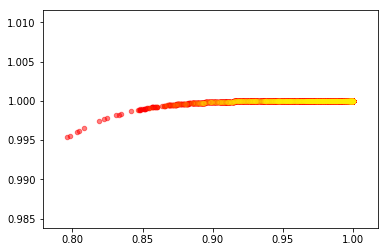

In [14]:
b1 = plt.scatter(X_reduce['x'][X_reduce.label == 1], X_reduce['y'][X_reduce.label == 1], c= 'red', s= 20, alpha= 0.5)
b1 = plt.scatter(X_reduce['x'][X_reduce.label == 0], X_reduce['y'][X_reduce.label == 0], c= 'yellow', s= 20, alpha= 0.05)

plt.show()

In [15]:
cnn_predict = autoencoder.predict(train_seq)
cnn_predict.shape

(5722, 50, 17, 1)

In [16]:
cnn_predict = cnn_predict.reshape(cnn_predict.shape[0],cnn_predict.shape[1]*cnn_predict.shape[2]*cnn_predict.shape[3])
print(cnn_predict.shape)

(5722, 850)


In [17]:
train_seq2 = train_seq.reshape(train_seq.shape[0], train_seq.shape[1]* train_seq.shape[2]* train_seq.shape[3])
print(train_seq2.shape)

(5722, 850)


In [18]:
### calculate MSE
mse = mean_squared_error(train_seq2.T, cnn_predict.T, multioutput='raw_values')
mse.shape

(5722,)

In [19]:
np.max(mse), np.min(mse) , np.mean(mse)

(3.299199400998875, 0.2986341987558705, 0.7723522668932832)

In [35]:
### labeling
# mse < border
border = 0.7
label= [0 if  mse[x] < border else 1 for x in range(0,len(mse)) ]
X_reduce['label'] = label
idx_0 = X_reduce[X_reduce.label == 0].index
idx_1 = X_reduce[X_reduce.label == 1].index
print(len(idx_0))
print(len(idx_1))

3264
2458


In [36]:
idx_1

Int64Index([  54,   55,   56,   57,   58,   59,   60,   61,   62,   63,
            ...
            5662, 5663, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721],
           dtype='int64', length=2458)

In [37]:
np.sum(train_seq_label)

2400

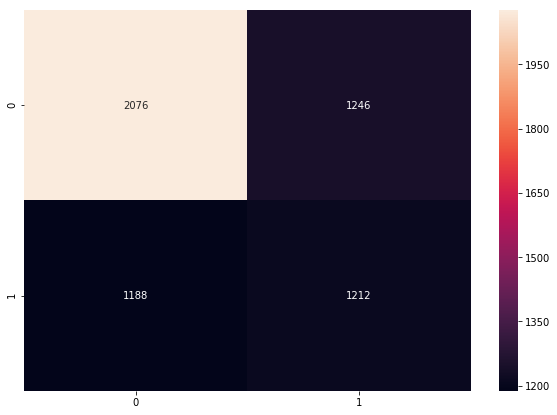

In [38]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(train_seq_label, X_reduce['label']))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

In [24]:
np.where(train_seq_label[idx_1]==0)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  51,  52,  53,  54,  55,  56,  57,  58,  77,  78, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 291, 292, 293, 294, 295, 296, 297, 298, 299,
        300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 318,
        319, 320, 321, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
        337, 338, 339, 340, 341, 342, 343, 344, 375, 376, 377, 378, 379,
        380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392,
        393, 394], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

In [25]:
train_seq_label[10:20]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)